In [1]:
! pip install kaggle
! pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! kaggle competitions download hms-harmful-brain-activity-classification
! kaggle datasets download cdeotte/brain-eeg-spectrograms
! kaggle datasets download cdeotte/Brain-Spectrograms

100% 18.4G/18.4G [02:34<00:00, 180MB/s]
100% 18.4G/18.4G [02:34<00:00, 128MB/s]
100% 14.9G/14.9G [01:57<00:00, 172MB/s]
100% 14.9G/14.9G [01:57<00:00, 136MB/s]
100% 2.66G/2.66G [00:28<00:00, 80.2MB/s]
100% 2.66G/2.66G [00:28<00:00, 100MB/s] 


In [12]:
! unzip /content/hms-harmful-brain-activity-classification.zip -d hms-harmful-brain-activity-classification
! unzip /content/brain-eeg-spectrograms.zip -d brain-eeg-spectrograms
! unzip /content/Brain-Spectrograms.zip -d Brain-Spectrograms

Streaming output truncated to the last 5000 lines.
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/373774228.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3737800790.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3737954452.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/373810434.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3738496190.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3738792818.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3739370975.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/373969525.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/373987935.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/374039955.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3740637372.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/3740820436.npy  
  inflating: brain-eeg-spectrograms/EEG_Spectrograms/374106652.npy  
  inflating: brain-eeg-spectrograms/EEG_Spect

In [13]:
! mkdir /content/output/

mkdir: cannot create directory ‘/content/output/’: File exists


# Code

In [15]:
import albumentations as A
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F


from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [16]:
class config:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 4
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e6
    MODEL = "tf_efficientnet_b0"
    NUM_FROZEN_LAYERS = 39
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01


class paths:
    OUTPUT_DIR = "/content/output/"
    PRE_LOADED_EEGS = '/content/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTOGRAMS = '/content/Brain-Spectrograms/specs.npy'

    TRAIN_CSV = "/content/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/content/brain-eeg-spectrograms/EEG_Spectrograms/"
    TRAIN_SPECTOGRAMS = "/content/hms-harmful-brain-activity-classification/train_spectrograms/"

In [17]:
# Utils

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)

    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def sep():
    print("-"*100)


target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

In [18]:
# Load data

df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]
print(f"Train cataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")
df.head()

Train cataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [19]:
# Data preprocessing

train_df = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_id':'first',
    'spectrogram_label_offset_seconds':'min'
})
train_df.columns = ['spectogram_id','min']

aux = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_label_offset_seconds':'max'
})
train_df['max'] = aux

aux = df.groupby('eeg_id')[['patient_id']].agg('first')
train_df['patient_id'] = aux

aux = df.groupby('eeg_id')[label_cols].agg('sum')
for label in label_cols:
    train_df[label] = aux[label].values

y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
print('Train non-overlapp eeg_id shape:', train_df.shape )
train_df.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spectogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


There are 11138 spectrogram parquets


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


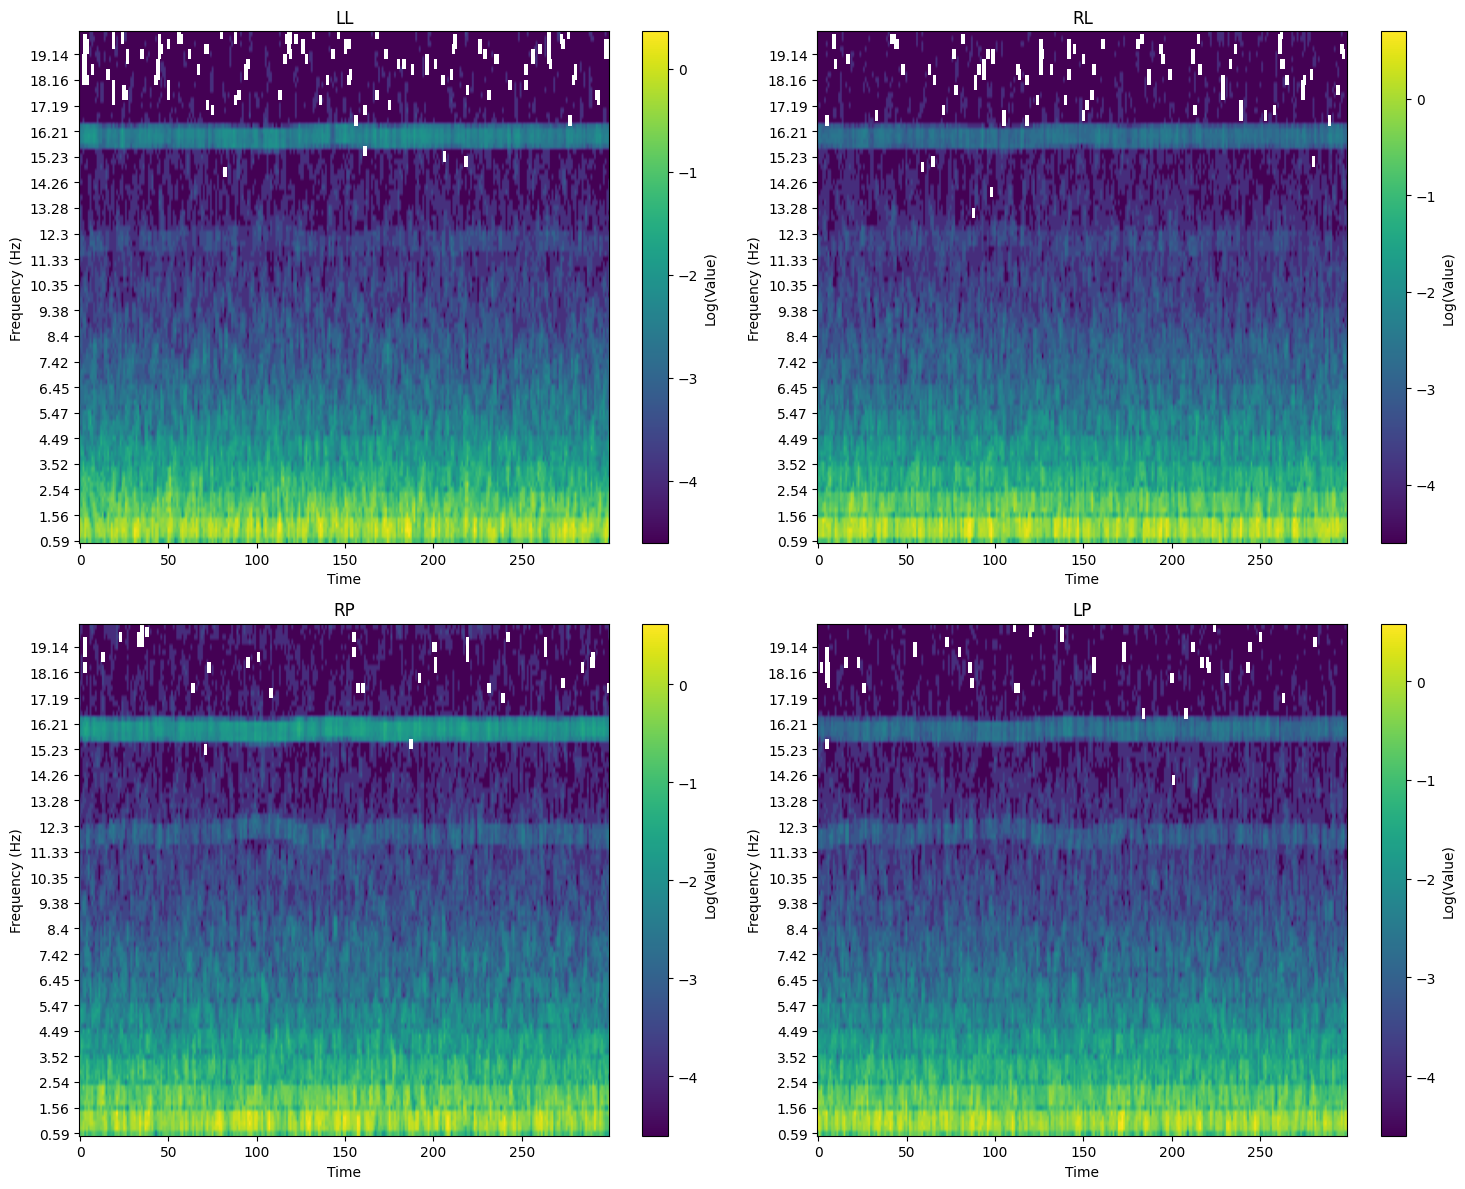

CPU times: user 2.63 s, sys: 4.53 s, total: 7.15 s
Wall time: 6.72 s


In [20]:
# Read train spectrogram

%%time
READ_SPEC_FILES = False

paths_spectograms = glob(paths.TRAIN_SPECTOGRAMS + "*.parquet")
print(f'There are {len(paths_spectograms)} spectrogram parquets')

if READ_SPEC_FILES:
    all_spectrograms = {}
    for file_path in tqdm(paths_spectograms):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_spectrograms[name] = aux.iloc[:,1:].values
        del aux
else:
    all_spectrograms = np.load(paths.PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()

if config.VISUALIZE:
    idx = np.random.randint(0,len(paths_spectograms))
    spectrogram_path = paths_spectograms[idx]
    plot_spectrogram(spectrogram_path)

In [21]:
# Read EEG spectrogram

%%time
READ_EEG_SPEC_FILES = False

paths_eegs = glob(paths.TRAIN_EEGS + "*.npy")
print(f'There are {len(paths_eegs)} EEG spectograms')

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for file_path in tqdm(paths_eegs):
        eeg_id = file_path.split("/")[-1].split(".")[0]
        eeg_spectogram = np.load(file_path)
        all_eegs[eeg_id] = eeg_spectogram
else:
    all_eegs = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()


There are 17089 EEG spectograms
CPU times: user 197 ms, sys: 5.46 s, total: 5.66 s
Wall time: 5.64 s


In [22]:
# Validation
from sklearn.model_selection import KFold, GroupKFold

gkf = GroupKFold(n_splits=config.FOLDS)
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):
    train_df.loc[valid_index, "fold"] = int(fold)

display(train_df.groupby('fold').size()), sep()
display(train_df.head())

fold
0.0    3418
1.0    3418
2.0    3418
3.0    3418
4.0    3417
dtype: int64

----------------------------------------------------------------------------------------------------


,eeg_id,spectogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,1.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,0.0


In [23]:
# Dataset

class CustomDataset_split(Dataset):
    def __init__(
        self, df: pd.DataFrame, config,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = all_spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs
    ):
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.augment = augment
        self.mode = mode
        self.spectograms = all_spectrograms
        self.eeg_spectograms = eeg_specs

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X_eeg, X_spect, y = self.__data_generation(index)
        if self.augment:
            X_eeg = self.__transform(X_eeg)
            X_spect = self.__transform(X_spect)
        return torch.tensor(X_eeg, dtype=torch.float32), torch.tensor(X_spect, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X_eeg = np.zeros((128, 256, 4), dtype='float32')
        X_spect = np.zeros((128, 256, 4), dtype='float32')
        y = np.zeros(6, dtype='float32')

        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        if self.mode=='test':
            r = 0
        else:
            r = int((row['min'] + row['max']) // 4)

        for region in range(4):
            img = self.spectograms[row.spectogram_id][r:r+300, region*100:(region+1)*100].T

            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X_spect[14:-14, :, region] = img[:, 22:-22] / 2.0

            img = self.eeg_spectograms[row.eeg_id]
            X_eeg = img

            if self.mode != 'test':
                y = row[label_cols].values.astype(np.float32)

        return X_eeg, X_spect, y

    def __transform(self, img):
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
        ])
        return transforms(image=img)['image']

In [24]:
# Dataloader

train_dataset = CustomDataset_split(train_df, config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
X_eeg, X_spect, y = train_dataset[0]
print(f"X shape: {X_eeg.shape}")
print(f"X shape: {X_spect.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([128, 256, 4])
X shape: torch.Size([128, 256, 4])
y shape: torch.Size([6])


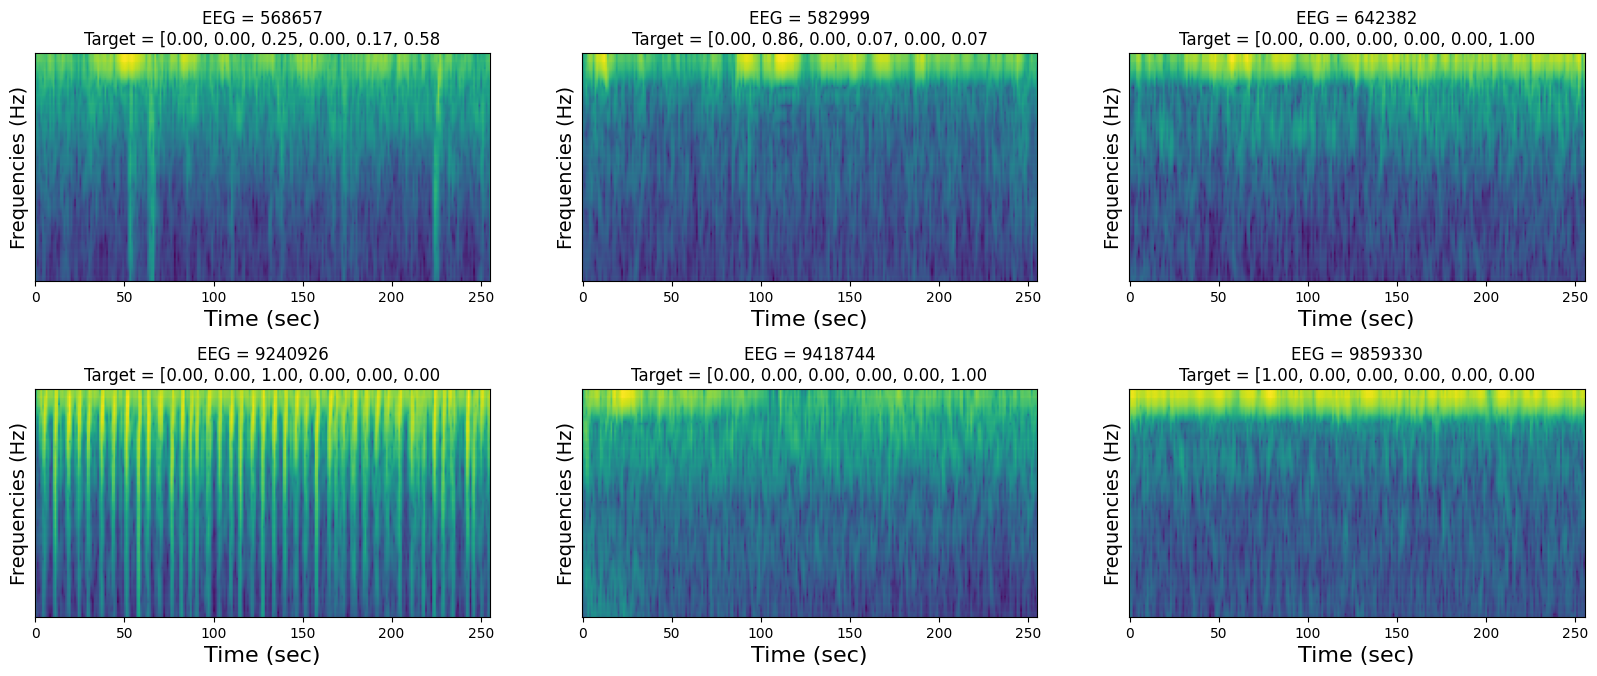

In [25]:
if config.VISUALIZE:
    ROWS = 2
    COLS = 3
    for (X_eeg, X_spect, y) in train_loader:
        plt.figure(figsize=(20,8))
        for row in range(ROWS):
            for col in range(COLS):
                plt.subplot(ROWS, COLS, row*COLS + col+1)
                t = y[row*COLS + col]
                img = X_eeg[row*COLS + col, :, :, 0]
                mn = img.flatten().min()
                mx = img.flatten().max()
                img = (img-mn)/(mx-mn)
                plt.imshow(img)
                tars = f'[{t[0]:0.2f}'
                for s in t[1:]:
                    tars += f', {s:0.2f}'
                eeg = train_df.eeg_id.values[row*config.BATCH_SIZE_TRAIN + row*COLS + col]
                plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
                plt.yticks([])
                plt.ylabel('Frequencies (Hz)',size=14)
                plt.xlabel('Time (sec)',size=16)
        plt.show()
        break

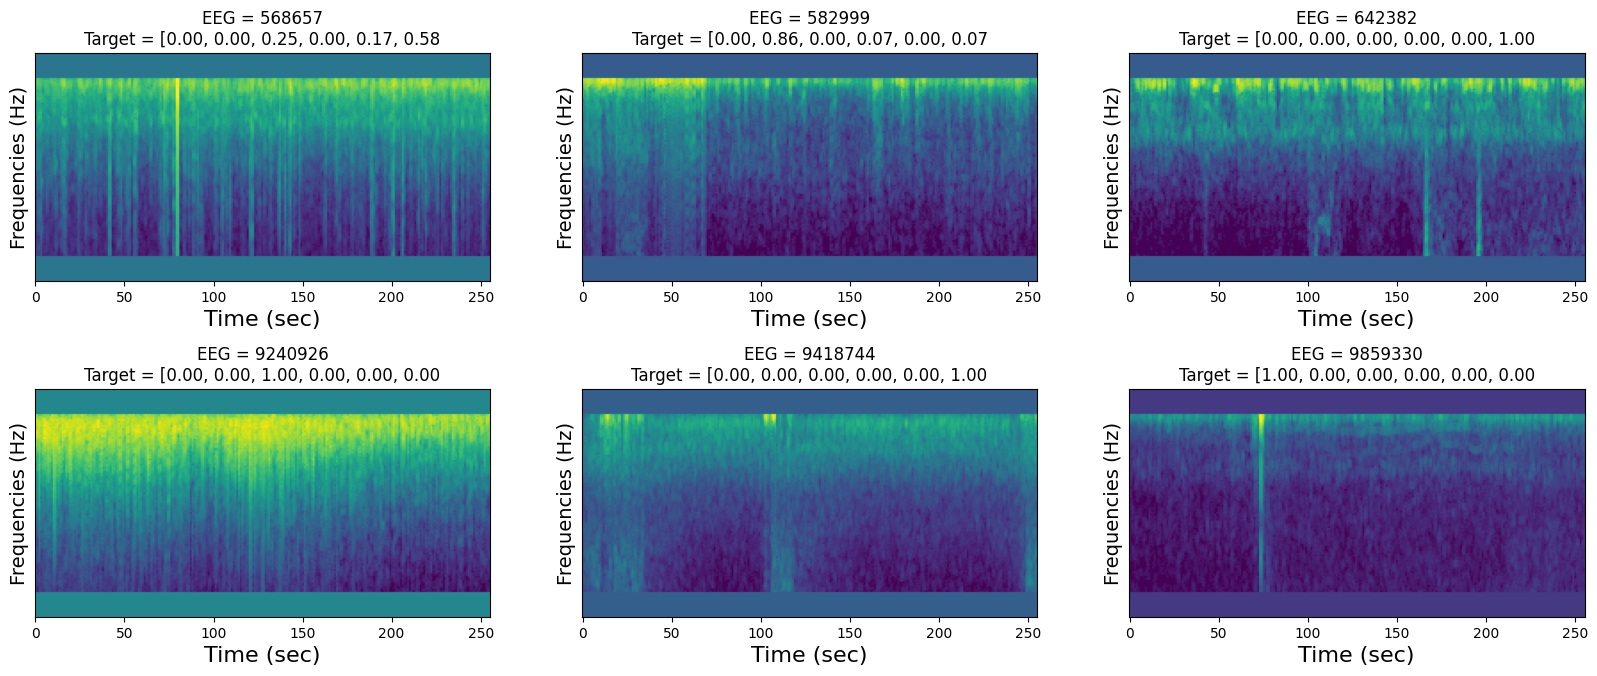

In [26]:
if config.VISUALIZE:
    ROWS = 2
    COLS = 3
    for (X_eeg, X_spect, y) in train_loader:
        plt.figure(figsize=(20,8))
        for row in range(ROWS):
            for col in range(COLS):
                plt.subplot(ROWS, COLS, row*COLS + col+1)
                t = y[row*COLS + col]
                img = X_spect[row*COLS + col, :, :, 0]
                mn = img.flatten().min()
                mx = img.flatten().max()
                img = (img-mn)/(mx-mn)
                plt.imshow(img)
                tars = f'[{t[0]:0.2f}'
                for s in t[1:]:
                    tars += f', {s:0.2f}'
                eeg = train_df.eeg_id.values[row*config.BATCH_SIZE_TRAIN + row*COLS + col]
                plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
                plt.yticks([])
                plt.ylabel('Frequencies (Hz)',size=14)
                plt.xlabel('Time (sec)',size=16)
        plt.show()
        break

# Model

1. Naive CNN
2. EfficientNet
3. Ensemble method

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 96, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(96, 128, kernel_size=3, padding=1)

        self.branch_pool = nn.Conv2d(in_channels, 32, kernel_size=1)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        # print(x.shape)
        branch1x1 = self.branch1x1(x)
        # print(branch1x1.shape)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        # print(branch5x5.shape)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        # print(branch3x3dbl.shape)

        branch_pool = self.max_pool(x)
        branch_pool = self.branch_pool(branch_pool)
        # print(branch_pool.shape)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        # print(output.shape)
        return torch.cat(outputs, 1)

# Example usage
# Let's say the input has 192 channels
inception_module = InceptionModule(in_channels=192)
# Dummy input tensor of shape (batch_size, in_channels, height, width)
dummy_input = torch.randn(1, 192, 28, 28)
output = inception_module(dummy_input)
print(output.size())  # This will print the size of the output tensor


torch.Size([1, 256, 28, 28])


In [39]:
class SimplifiedInceptionNet(nn.Module):
    def __init__(self):
        super(SimplifiedInceptionNet, self).__init__()

        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True

        # Assuming `nn.Sequential` is used to create the CNN layers.
        self.layers = nn.Sequential(
            # Convolution Layer 1: Reduce to 128x128
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2),  # Reduce to 64x64

            # Convolution Layer 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, stride=2),  # Reduce to 32x32

            # Convolution Layer 3
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.MaxPool2d(2, stride=2),  # Reduce to 16x16

            # Convolution Layer 4: Tune the final size closer to 28x28
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=0),  # Reduce to 14x14
            nn.BatchNorm2d(192),
            nn.ReLU(),

            # Upscale to 28x28 using ConvTranspose2d
            nn.ConvTranspose2d(
                192, 192, kernel_size=4, stride=2, padding=1, output_padding=0
            ),
            nn.ReLU()
        )

        self.inception_module = InceptionModule(in_channels = 192)

        self.pool = nn.AvgPool2d(2)  # Pooling layer to reduce dimensionality

        # Two fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 128) # 64*28*28 = 50176
        self.fc2 = nn.Linear(128, 6)

    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (256, 256, 3) monotone image.
        """
        x = torch.cat([x, x], dim=1)
        x = x[:, :, :, :3]  # Now shape [batch_size, 256, 256, 3]
        x = x.permute(0, 3, 1, 2)
        return x

    def forward(self, x):
        # print("input:", x.shape)
        x = self.__reshape_input(x) # 512 x 512 x 3
        # print("reshape:", x.shape)

        x = self.layers(x)
        # print("conv:", x.shape)

        x = self.inception_module(x)
        x = F.relu(x)
        # print("inception:", x.shape)
        emb = x.detach().clone()

        x = self.pool(x)  # Apply pooling here to reduce dimensions
        # print("pooling:", x.shape)

        batch_size = x.size(0)  # This will capture the current batch size dynamically
        x = x.reshape(batch_size, -1)
        # print(x.shape)

        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output, emb


# # Example usage
# # Let's say the input has 192 channels
# inception_net = SimplifiedInceptionNet()
# # Dummy input tensor of shape (batch_size, in_channels, height, width)
# dummy_input = torch.randn(2, 128, 256, 8) #(128, 256, 4)
# output, emb = inception_net(dummy_input)
# print(output.size())  # This will print the size of the output tensor
# print(emb.size())

In [43]:
class CombinedModel(nn.Module):
    def __init__(self, eeg_encoder, spectrogram_encoder):
        super(CombinedModel, self).__init__()
        self.eeg_encoder = eeg_encoder
        self.spectrogram_encoder = spectrogram_encoder
        self.fc1 = nn.Linear(512 * 28 * 28, 64)  # Adjust the size according to your output from encoders
        self.fc2 = nn.Linear(64, 6)  # Adjust the size according to your output from encoders

        self.batch_norm = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.5)  # Apply a dropout layer before the fully connected layers

    def forward(self, eeg_data, spectrogram_data):
        eeg_output, eeg_emb = self.eeg_encoder(eeg_data)
        spectrogram_output, spectrogram_emb = self.spectrogram_encoder(spectrogram_data)

        # Combine the outputs (e.g., by concatenating them)
        combined = torch.cat((eeg_emb, spectrogram_emb), dim=1)

        # Apply batch normalization
        combined = self.batch_norm(combined)

        # Flatten
        combined = combined.reshape(combined.size(0), -1)
        combined = self.dropout(combined)

        # Pass through a fully connected layer
        x = self.fc1(combined)
        overall_output = self.fc2(x)
        return eeg_emb, spectrogram_emb, eeg_output, spectrogram_output, overall_output


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaLoss(nn.Module):
    def __init__(self, weight_contrastive=1.0, weight_kldiv1=1.0, weight_kldiv2=0):
        super(MetaLoss, self).__init__()
        self.weight_contrastive = weight_contrastive
        self.weight_kldiv1 = weight_kldiv1
        self.weight_kldiv2 = weight_kldiv2
        self.contrastive_loss = nn.CosineEmbeddingLoss() # or any other contrastive loss
        self.kldiv_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, emb1, emb2, output1, output2, overall_output, label, target):
        """
        emb1: Embedding from encoder 1
        emb2: Embedding from encoder 2
        target: Target for contrastive loss, usually 1 for similar pairs and -1 for dissimilar pairs
        output: Logits from the model (output of softmax/log_softmax)
        label: Ground truth probabilities or labels for KLDiv loss
        """
        # Make sure all inputs are on the same device
        device = emb1.device  # Assumes emb1 is on the correct device, adjust as necessary
        emb2 = emb2.to(device)
        output1 = output1.to(device)
        output2 = output2.to(device)
        overall_output = overall_output.to(device)
        label = label.to(device)
        target = target.to(device)

        # flatten
        if emb1.dim() > 2:
            emb1 = F.adaptive_avg_pool2d(emb1, (1, 1)).view(emb1.size(0), -1)
        if emb2.dim() > 2:
            emb2 = F.adaptive_avg_pool2d(emb2, (1, 1)).view(emb2.size(0), -1)

        loss_contrastive = self.contrastive_loss(emb1, emb2, target)
        loss_kldiv1 = self.kldiv_loss(F.log_softmax(output1, dim=1), label)
        loss_kldiv2 = self.kldiv_loss(F.log_softmax(output2, dim=1), label)

        # Combine the losses with respective weights
        combined_loss = self.weight_contrastive * loss_contrastive + self.weight_kldiv1 * loss_kldiv1 + self.weight_kldiv2 * loss_kldiv2
        return combined_loss



Maximum LR: 0.0009999999760405812 | Minimum LR: 4.0000000000000003e-07


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


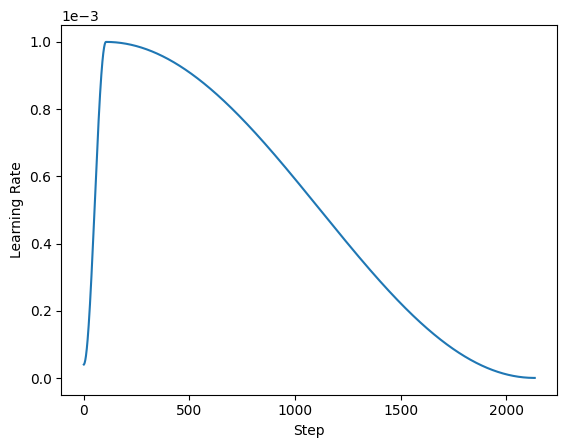

In [34]:
# Scheduler
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = config.EPOCHS
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
# model = CustomModel(config)
model = SimplifiedInceptionNet()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=config.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.05,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

In [35]:
def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=config.AMP)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, (X_eeg, X_spect, y) in enumerate(tqdm_train_loader):
            X_eeg = X_eeg.to(device)
            X_spect = X_spect.to(device)
            y = y.to(device)
            batch_size = y.size(0)

            with torch.cuda.amp.autocast(enabled=config.AMP):
                # print("X_eeg: ", X_eeg.shape)
                # print("X_spect: ", X_spect.shape)
                # print("y: ", y.shape)

                # Forward pass through your models to get the embeddings and outputs
                eeg_emb, spectrogram_emb, eeg_output, spectrogram_output, overall_output = model(X_eeg, X_spect)  # Assuming you have a combined model for KLDivLoss

                # Calculate target similarity values for contrastive loss (-1 or 1)
                targets = torch.ones(y.size(0)) # Assuming all pairs are similar; adjust as needed

                # Calculate the meta loss
                loss = criterion(eeg_emb, spectrogram_emb, eeg_output, spectrogram_output, overall_output, y, targets)


                # print("y pred:", y_preds.shape)
                # loss = criterion(F.log_softmax(y_preds, dim=1), y)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader),
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_last_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter()
    prediction_dict = {}
    preds = []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, (X_eeg, X_spect, y) in enumerate(tqdm_valid_loader):
            X_eeg = X_eeg.to(device)
            X_spect = X_spect.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                # Forward pass through your models to get the embeddings and outputs
                eeg_emb, spectrogram_emb, eeg_output, spectrogram_output, overall_output = model(X_eeg, X_spect)  # Assuming you have a combined model for KLDivLoss

                # Calculate target similarity values for contrastive loss (-1 or 1)
                targets = torch.ones(y.size(0)) # Assuming all pairs are similar; adjust as needed

                # Calculate the meta loss
                loss = criterion(eeg_emb, spectrogram_emb, eeg_output, spectrogram_output, overall_output, y, targets)
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            y_preds = softmax(overall_output)
            preds.append(y_preds.to('cpu').numpy())
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              remain=timeSince(start, float(step+1)/len(valid_loader)),
                              loss=losses))

    prediction_dict["predictions"] = np.concatenate(preds)
    return losses.avg, prediction_dict

In [36]:
def train_loop(df, fold):

    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)

    # ======== DATASETS ==========
    train_dataset = CustomDataset_split(train_folds, config, mode="train", augment=True)
    valid_dataset = CustomDataset_split(valid_folds, config, mode="train", augment=False)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ======== MODEL ==========
    # Initialize models
    eeg_encoder = SimplifiedInceptionNet()
    spectrogram_encoder = SimplifiedInceptionNet()
    model = CombinedModel(eeg_encoder, spectrogram_encoder)
    # model = SimplifiedInceptionNet()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    # criterion = nn.KLDivLoss(reduction="batchmean")
    criterion = MetaLoss()

    best_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]

        # ======= SCORING ==========
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")

    predictions = torch.load(paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth",
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[target_preds] = predictions

    torch.cuda.empty_cache()
    gc.collect()

    return valid_folds

In [37]:
def train_loop_full_data(df):
    train_dataset = CustomDataset_split(df, config, mode="train", augment=True)
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)

    eeg_encoder = SimplifiedInceptionNet()
    spectrogram_encoder = SimplifiedInceptionNet()
    model = CombinedModel(eeg_encoder, spectrogram_encoder)
    # model = SimplifiedInceptionNet()
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    criterion = MetaLoss()
    best_loss = np.inf
    for epoch in range(config.EPOCHS):
        start_time = time.time()
        avg_train_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        elapsed = time.time() - start_time
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  time: {elapsed:.0f}s')
        torch.save(
            {'model': model.state_dict()},
            paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_epoch_{epoch}.pth")
    torch.cuda.empty_cache()
    gc.collect()
    return _

In [44]:
def get_result(oof_df):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    labels = torch.tensor(oof_df[label_cols].values)
    preds = torch.tensor(oof_df[target_preds].values)
    preds = F.log_softmax(preds, dim=1)
    result = kl_loss(preds, labels)
    return result

if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(train_df, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
            print(f"========== Fold {fold} result: {get_result(_oof_df)} ==========")
    oof_df = oof_df.reset_index(drop=True)
    LOGGER.info(f"========== CV: {get_result(oof_df)} ==========")
    oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
else:
    train_loop_full_data(train_df)

========== Fold: 0 training ==========
========== Fold: 0 training ==========
INFO:__main__:========== Fold: 0 training ==========
Train:   0%|          | 1/427 [00:00<04:50,  1.47train_batch/s]

Epoch: [1][0/427] Elapsed 0m 0s (remain 4m 50s) Loss: 2.0223 Grad: 116608.5000  LR: 0.00004008  


Train:   5%|▍         | 21/427 [00:05<01:28,  4.58train_batch/s]

Epoch: [1][20/427] Elapsed 0m 5s (remain 1m 38s) Loss: 1.8760 Grad: 47085.9570  LR: 0.00007578  


Train:  10%|▉         | 41/427 [00:09<01:20,  4.82train_batch/s]

Epoch: [1][40/427] Elapsed 0m 9s (remain 1m 26s) Loss: 1.8514 Grad: 57222.4375  LR: 0.00017161  


Train:  14%|█▍        | 61/427 [00:13<01:16,  4.76train_batch/s]

Epoch: [1][60/427] Elapsed 0m 13s (remain 1m 20s) Loss: 1.8274 Grad: 158590.7031  LR: 0.00031460  


Train:  19%|█▉        | 81/427 [00:17<01:13,  4.71train_batch/s]

Epoch: [1][80/427] Elapsed 0m 17s (remain 1m 15s) Loss: 1.8149 Grad: 80130.3516  LR: 0.00048539  


Train:  24%|██▎       | 101/427 [00:21<01:09,  4.71train_batch/s]

Epoch: [1][100/427] Elapsed 0m 21s (remain 1m 10s) Loss: 1.8140 Grad: 97410.0156  LR: 0.00066088  


Train:  28%|██▊       | 121/427 [00:26<01:05,  4.65train_batch/s]

Epoch: [1][120/427] Elapsed 0m 26s (remain 1m 6s) Loss: 1.8166 Grad: inf  LR: 0.00081729  


Train:  33%|███▎      | 141/427 [00:30<01:04,  4.40train_batch/s]

Epoch: [1][140/427] Elapsed 0m 30s (remain 1m 1s) Loss: 1.8219 Grad: 92019.4766  LR: 0.00093345  


Train:  38%|███▊      | 161/427 [00:34<00:57,  4.62train_batch/s]

Epoch: [1][160/427] Elapsed 0m 34s (remain 0m 57s) Loss: 1.8238 Grad: 54838.7422  LR: 0.00099365  


Train:  42%|████▏     | 181/427 [00:39<00:51,  4.80train_batch/s]

Epoch: [1][180/427] Elapsed 0m 39s (remain 0m 53s) Loss: 1.8131 Grad: 83296.5547  LR: 0.00099987  


Train:  47%|████▋     | 201/427 [00:43<00:47,  4.74train_batch/s]

Epoch: [1][200/427] Elapsed 0m 43s (remain 0m 48s) Loss: 1.8076 Grad: 74639.3516  LR: 0.00099898  


Train:  52%|█████▏    | 221/427 [00:47<00:44,  4.58train_batch/s]

Epoch: [1][220/427] Elapsed 0m 47s (remain 0m 44s) Loss: 1.8039 Grad: 73389.2266  LR: 0.00099727  


Train:  56%|█████▋    | 241/427 [00:51<00:40,  4.63train_batch/s]

Epoch: [1][240/427] Elapsed 0m 51s (remain 0m 39s) Loss: 1.8011 Grad: 124740.3828  LR: 0.00099472  


Train:  61%|██████    | 261/427 [00:56<00:35,  4.72train_batch/s]

Epoch: [1][260/427] Elapsed 0m 56s (remain 0m 35s) Loss: 1.7983 Grad: 59680.2227  LR: 0.00099134  


Train:  66%|██████▌   | 281/427 [01:00<00:31,  4.68train_batch/s]

Epoch: [1][280/427] Elapsed 1m 0s (remain 0m 31s) Loss: 1.7908 Grad: 45412.3828  LR: 0.00098715  


Train:  70%|███████   | 301/427 [01:04<00:26,  4.79train_batch/s]

Epoch: [1][300/427] Elapsed 1m 4s (remain 0m 27s) Loss: 1.7841 Grad: 41942.5352  LR: 0.00098214  


Train:  75%|███████▌  | 321/427 [01:08<00:22,  4.76train_batch/s]

Epoch: [1][320/427] Elapsed 1m 8s (remain 0m 22s) Loss: 1.7790 Grad: 37263.6602  LR: 0.00097633  


Train:  80%|███████▉  | 341/427 [01:12<00:18,  4.74train_batch/s]

Epoch: [1][340/427] Elapsed 1m 12s (remain 0m 18s) Loss: 1.7768 Grad: 37666.2070  LR: 0.00096972  


Train:  85%|████████▍ | 361/427 [01:17<00:13,  4.78train_batch/s]

Epoch: [1][360/427] Elapsed 1m 17s (remain 0m 14s) Loss: 1.7715 Grad: 41408.9688  LR: 0.00096233  


Train:  89%|████████▉ | 381/427 [01:21<00:09,  4.77train_batch/s]

Epoch: [1][380/427] Elapsed 1m 21s (remain 0m 9s) Loss: 1.7633 Grad: 44668.6016  LR: 0.00095416  


Train:  94%|█████████▍| 401/427 [01:25<00:05,  4.64train_batch/s]

Epoch: [1][400/427] Elapsed 1m 25s (remain 0m 5s) Loss: 1.7590 Grad: 33403.5000  LR: 0.00094524  


Train:  99%|█████████▊| 421/427 [01:29<00:01,  4.78train_batch/s]

Epoch: [1][420/427] Elapsed 1m 29s (remain 0m 1s) Loss: 1.7521 Grad: 45178.1797  LR: 0.00093557  


Train: 100%|██████████| 427/427 [01:31<00:00,  4.69train_batch/s]


Epoch: [1][426/427] Elapsed 1m 31s (remain 0m 0s) Loss: 1.7517 Grad: 32917.5625  LR: 0.00093253  


Validation:   1%|          | 1/107 [00:00<00:35,  3.02valid_batch/s]

EVAL: [0/107] Elapsed 0m 0s (remain 0m 35s) Loss: 2.3464 


Validation:  21%|██        | 22/107 [00:04<00:16,  5.25valid_batch/s]

EVAL: [20/107] Elapsed 0m 4s (remain 0m 17s) Loss: 2.2959 


Validation:  39%|███▉      | 42/107 [00:08<00:12,  5.32valid_batch/s]

EVAL: [40/107] Elapsed 0m 7s (remain 0m 12s) Loss: 2.2910 


Validation:  58%|█████▊    | 62/107 [00:11<00:08,  5.28valid_batch/s]

EVAL: [60/107] Elapsed 0m 11s (remain 0m 8s) Loss: 2.2823 


Validation:  77%|███████▋  | 82/107 [00:15<00:04,  5.24valid_batch/s]

EVAL: [80/107] Elapsed 0m 15s (remain 0m 4s) Loss: 2.2707 


Validation:  94%|█████████▍| 101/107 [00:19<00:01,  5.29valid_batch/s]

EVAL: [100/107] Elapsed 0m 19s (remain 0m 1s) Loss: 2.2701 


Validation: 100%|██████████| 107/107 [00:20<00:00,  5.21valid_batch/s]
Epoch 1 - avg_train_loss: 1.7517  avg_val_loss: 2.2711  time: 112s
Epoch 1 - avg_train_loss: 1.7517  avg_val_loss: 2.2711  time: 112s
INFO:__main__:Epoch 1 - avg_train_loss: 1.7517  avg_val_loss: 2.2711  time: 112s
Epoch 1 - Save Best Loss: 2.2711 Model
Epoch 1 - Save Best Loss: 2.2711 Model
INFO:__main__:Epoch 1 - Save Best Loss: 2.2711 Model


EVAL: [106/107] Elapsed 0m 20s (remain 0m 0s) Loss: 2.2711 


Train:   0%|          | 1/427 [00:00<01:30,  4.70train_batch/s]

Epoch: [2][0/427] Elapsed 0m 0s (remain 1m 30s) Loss: 1.6781 Grad: 172676.5938  LR: 0.00093201  


Train:   5%|▍         | 21/427 [00:04<01:25,  4.74train_batch/s]

Epoch: [2][20/427] Elapsed 0m 4s (remain 1m 24s) Loss: 1.5890 Grad: 92804.5703  LR: 0.00092137  


Train:  10%|▉         | 41/427 [00:08<01:21,  4.76train_batch/s]

Epoch: [2][40/427] Elapsed 0m 8s (remain 1m 20s) Loss: 1.5702 Grad: 103573.6719  LR: 0.00091002  


Train:  14%|█▍        | 61/427 [00:12<01:16,  4.76train_batch/s]

Epoch: [2][60/427] Elapsed 0m 12s (remain 1m 16s) Loss: 1.5791 Grad: 58222.4180  LR: 0.00089799  


Train:  19%|█▉        | 81/427 [00:16<01:12,  4.76train_batch/s]

Epoch: [2][80/427] Elapsed 0m 16s (remain 1m 12s) Loss: 1.5823 Grad: 59778.5742  LR: 0.00088529  


Train:  24%|██▎       | 101/427 [00:21<01:09,  4.72train_batch/s]

Epoch: [2][100/427] Elapsed 0m 21s (remain 1m 8s) Loss: 1.5932 Grad: 126860.7891  LR: 0.00087195  


Train:  28%|██▊       | 121/427 [00:25<01:04,  4.76train_batch/s]

Epoch: [2][120/427] Elapsed 0m 25s (remain 1m 3s) Loss: 1.5933 Grad: 165987.5938  LR: 0.00085799  


Train:  33%|███▎      | 141/427 [00:29<00:59,  4.84train_batch/s]

Epoch: [2][140/427] Elapsed 0m 29s (remain 0m 59s) Loss: 1.5948 Grad: 65295.8320  LR: 0.00084343  


Train:  38%|███▊      | 161/427 [00:33<00:55,  4.82train_batch/s]

Epoch: [2][160/427] Elapsed 0m 33s (remain 0m 55s) Loss: 1.5873 Grad: 83440.5938  LR: 0.00082830  


Train:  42%|████▏     | 181/427 [00:37<00:51,  4.76train_batch/s]

Epoch: [2][180/427] Elapsed 0m 37s (remain 0m 51s) Loss: 1.5792 Grad: 127440.7578  LR: 0.00081262  


Train:  47%|████▋     | 201/427 [00:41<00:47,  4.76train_batch/s]

Epoch: [2][200/427] Elapsed 0m 41s (remain 0m 47s) Loss: 1.5738 Grad: 74897.3281  LR: 0.00079642  


Train:  52%|█████▏    | 221/427 [00:46<00:43,  4.75train_batch/s]

Epoch: [2][220/427] Elapsed 0m 46s (remain 0m 42s) Loss: 1.5729 Grad: 80251.5703  LR: 0.00077972  


Train:  56%|█████▋    | 241/427 [00:50<00:38,  4.77train_batch/s]

Epoch: [2][240/427] Elapsed 0m 50s (remain 0m 38s) Loss: 1.5756 Grad: 99795.1875  LR: 0.00076255  


Train:  61%|██████    | 261/427 [00:54<00:34,  4.78train_batch/s]

Epoch: [2][260/427] Elapsed 0m 54s (remain 0m 34s) Loss: 1.5746 Grad: 92369.8281  LR: 0.00074495  


Train:  66%|██████▌   | 281/427 [00:58<00:30,  4.78train_batch/s]

Epoch: [2][280/427] Elapsed 0m 58s (remain 0m 30s) Loss: 1.5745 Grad: 100255.1172  LR: 0.00072694  


Train:  70%|███████   | 301/427 [01:02<00:26,  4.77train_batch/s]

Epoch: [2][300/427] Elapsed 1m 2s (remain 0m 26s) Loss: 1.5711 Grad: 116133.3047  LR: 0.00070855  


Train:  75%|███████▌  | 321/427 [01:06<00:21,  4.83train_batch/s]

Epoch: [2][320/427] Elapsed 1m 6s (remain 0m 22s) Loss: 1.5676 Grad: 86155.3125  LR: 0.00068981  


Train:  80%|███████▉  | 341/427 [01:11<00:18,  4.76train_batch/s]

Epoch: [2][340/427] Elapsed 1m 11s (remain 0m 17s) Loss: 1.5664 Grad: 57174.8516  LR: 0.00067076  


Train:  85%|████████▍ | 361/427 [01:15<00:13,  4.77train_batch/s]

Epoch: [2][360/427] Elapsed 1m 15s (remain 0m 13s) Loss: 1.5662 Grad: 99031.8516  LR: 0.00065142  


Train:  89%|████████▉ | 381/427 [01:19<00:09,  4.82train_batch/s]

Epoch: [2][380/427] Elapsed 1m 19s (remain 0m 9s) Loss: 1.5615 Grad: 51131.5859  LR: 0.00063183  


Train:  94%|█████████▍| 401/427 [01:23<00:05,  4.74train_batch/s]

Epoch: [2][400/427] Elapsed 1m 23s (remain 0m 5s) Loss: 1.5621 Grad: 100372.7578  LR: 0.00061201  


Train:  99%|█████████▊| 421/427 [01:27<00:01,  4.72train_batch/s]

Epoch: [2][420/427] Elapsed 1m 27s (remain 0m 1s) Loss: 1.5582 Grad: 52829.2344  LR: 0.00059201  


Train: 100%|██████████| 427/427 [01:29<00:00,  4.79train_batch/s]


Epoch: [2][426/427] Elapsed 1m 29s (remain 0m 0s) Loss: 1.5581 Grad: 98127.9766  LR: 0.00058598  


Validation:   1%|          | 1/107 [00:00<00:20,  5.22valid_batch/s]

EVAL: [0/107] Elapsed 0m 0s (remain 0m 20s) Loss: 3.1850 


Validation:  21%|██        | 22/107 [00:04<00:15,  5.31valid_batch/s]

EVAL: [20/107] Elapsed 0m 3s (remain 0m 16s) Loss: 3.0863 


Validation:  39%|███▉      | 42/107 [00:07<00:12,  5.28valid_batch/s]

EVAL: [40/107] Elapsed 0m 7s (remain 0m 12s) Loss: 3.0546 


Validation:  58%|█████▊    | 62/107 [00:11<00:08,  5.26valid_batch/s]

EVAL: [60/107] Elapsed 0m 11s (remain 0m 8s) Loss: 3.0404 


Validation:  77%|███████▋  | 82/107 [00:15<00:04,  5.35valid_batch/s]

EVAL: [80/107] Elapsed 0m 15s (remain 0m 4s) Loss: 3.0195 


Validation:  94%|█████████▍| 101/107 [00:19<00:01,  5.24valid_batch/s]

EVAL: [100/107] Elapsed 0m 19s (remain 0m 1s) Loss: 3.0197 


Validation: 100%|██████████| 107/107 [00:20<00:00,  5.29valid_batch/s]
Epoch 2 - avg_train_loss: 1.5581  avg_val_loss: 3.0222  time: 109s
Epoch 2 - avg_train_loss: 1.5581  avg_val_loss: 3.0222  time: 109s
INFO:__main__:Epoch 2 - avg_train_loss: 1.5581  avg_val_loss: 3.0222  time: 109s


EVAL: [106/107] Elapsed 0m 20s (remain 0m 0s) Loss: 3.0222 


Train:   0%|          | 1/427 [00:00<01:33,  4.56train_batch/s]

Epoch: [3][0/427] Elapsed 0m 0s (remain 1m 33s) Loss: 1.5601 Grad: 249961.3750  LR: 0.00058498  


Train:   5%|▍         | 21/427 [00:04<01:25,  4.78train_batch/s]

Epoch: [3][20/427] Elapsed 0m 4s (remain 1m 24s) Loss: 1.4735 Grad: 96984.2656  LR: 0.00056478  


Train:  10%|▉         | 41/427 [00:08<01:20,  4.77train_batch/s]

Epoch: [3][40/427] Elapsed 0m 8s (remain 1m 20s) Loss: 1.4441 Grad: 76377.1875  LR: 0.00054447  


Train:  14%|█▍        | 61/427 [00:12<01:16,  4.81train_batch/s]

Epoch: [3][60/427] Elapsed 0m 12s (remain 1m 16s) Loss: 1.4505 Grad: 107399.6641  LR: 0.00052409  


Train:  19%|█▉        | 81/427 [00:16<01:12,  4.75train_batch/s]

Epoch: [3][80/427] Elapsed 0m 16s (remain 1m 12s) Loss: 1.4667 Grad: 73498.2812  LR: 0.00050367  


Train:  24%|██▎       | 101/427 [00:21<01:08,  4.77train_batch/s]

Epoch: [3][100/427] Elapsed 0m 21s (remain 1m 8s) Loss: 1.4816 Grad: 62869.2734  LR: 0.00048325  


Train:  28%|██▊       | 121/427 [00:25<01:03,  4.82train_batch/s]

Epoch: [3][120/427] Elapsed 0m 25s (remain 1m 3s) Loss: 1.4805 Grad: 101977.7891  LR: 0.00046285  


Train:  33%|███▎      | 141/427 [00:29<00:59,  4.82train_batch/s]

Epoch: [3][140/427] Elapsed 0m 29s (remain 0m 59s) Loss: 1.4794 Grad: 82047.9688  LR: 0.00044251  


Train:  38%|███▊      | 161/427 [00:33<00:55,  4.75train_batch/s]

Epoch: [3][160/427] Elapsed 0m 33s (remain 0m 55s) Loss: 1.4788 Grad: 79223.8828  LR: 0.00042228  


Train:  42%|████▏     | 181/427 [00:37<00:51,  4.79train_batch/s]

Epoch: [3][180/427] Elapsed 0m 37s (remain 0m 51s) Loss: 1.4734 Grad: 118360.3984  LR: 0.00040217  


Train:  47%|████▋     | 201/427 [00:41<00:47,  4.80train_batch/s]

Epoch: [3][200/427] Elapsed 0m 41s (remain 0m 47s) Loss: 1.4713 Grad: 81513.5078  LR: 0.00038222  


Train:  52%|█████▏    | 221/427 [00:46<00:43,  4.74train_batch/s]

Epoch: [3][220/427] Elapsed 0m 46s (remain 0m 42s) Loss: 1.4681 Grad: 85312.6406  LR: 0.00036248  


Train:  56%|█████▋    | 241/427 [00:50<00:38,  4.77train_batch/s]

Epoch: [3][240/427] Elapsed 0m 50s (remain 0m 38s) Loss: 1.4695 Grad: 84104.5781  LR: 0.00034296  


Train:  61%|██████    | 261/427 [00:54<00:34,  4.78train_batch/s]

Epoch: [3][260/427] Elapsed 0m 54s (remain 0m 34s) Loss: 1.4674 Grad: 89153.9297  LR: 0.00032370  


Train:  66%|██████▌   | 281/427 [00:58<00:30,  4.74train_batch/s]

Epoch: [3][280/427] Elapsed 0m 58s (remain 0m 30s) Loss: 1.4682 Grad: 76773.4688  LR: 0.00030474  


Train:  70%|███████   | 301/427 [01:02<00:26,  4.82train_batch/s]

Epoch: [3][300/427] Elapsed 1m 2s (remain 0m 26s) Loss: 1.4639 Grad: 85703.8594  LR: 0.00028611  


Train:  75%|███████▌  | 321/427 [01:06<00:22,  4.81train_batch/s]

Epoch: [3][320/427] Elapsed 1m 6s (remain 0m 22s) Loss: 1.4599 Grad: 99205.4219  LR: 0.00026783  


Train:  80%|███████▉  | 341/427 [01:11<00:18,  4.69train_batch/s]

Epoch: [3][340/427] Elapsed 1m 11s (remain 0m 17s) Loss: 1.4584 Grad: 76136.9609  LR: 0.00024995  


Train:  85%|████████▍ | 361/427 [01:15<00:13,  4.82train_batch/s]

Epoch: [3][360/427] Elapsed 1m 15s (remain 0m 13s) Loss: 1.4564 Grad: 108358.9062  LR: 0.00023248  


Train:  89%|████████▉ | 381/427 [01:19<00:09,  4.75train_batch/s]

Epoch: [3][380/427] Elapsed 1m 19s (remain 0m 9s) Loss: 1.4523 Grad: 57802.1406  LR: 0.00021545  


Train:  94%|█████████▍| 401/427 [01:23<00:05,  4.78train_batch/s]

Epoch: [3][400/427] Elapsed 1m 23s (remain 0m 5s) Loss: 1.4518 Grad: 84078.9062  LR: 0.00019891  


Train:  99%|█████████▊| 421/427 [01:27<00:01,  4.87train_batch/s]

Epoch: [3][420/427] Elapsed 1m 27s (remain 0m 1s) Loss: 1.4492 Grad: 64499.9492  LR: 0.00018286  


Train: 100%|██████████| 427/427 [01:28<00:00,  4.80train_batch/s]


Epoch: [3][426/427] Elapsed 1m 28s (remain 0m 0s) Loss: 1.4485 Grad: 75320.0859  LR: 0.00017815  


Validation:   2%|▏         | 2/107 [00:00<00:19,  5.26valid_batch/s]

EVAL: [0/107] Elapsed 0m 0s (remain 0m 21s) Loss: 2.8188 


Validation:  21%|██        | 22/107 [00:04<00:16,  5.20valid_batch/s]

EVAL: [20/107] Elapsed 0m 4s (remain 0m 16s) Loss: 2.6873 


Validation:  39%|███▉      | 42/107 [00:08<00:12,  5.32valid_batch/s]

EVAL: [40/107] Elapsed 0m 7s (remain 0m 12s) Loss: 2.6715 


Validation:  58%|█████▊    | 62/107 [00:11<00:08,  5.23valid_batch/s]

EVAL: [60/107] Elapsed 0m 11s (remain 0m 8s) Loss: 2.6596 


Validation:  77%|███████▋  | 82/107 [00:15<00:04,  5.23valid_batch/s]

EVAL: [80/107] Elapsed 0m 15s (remain 0m 4s) Loss: 2.6417 


Validation:  95%|█████████▌| 102/107 [00:19<00:00,  5.13valid_batch/s]

EVAL: [100/107] Elapsed 0m 19s (remain 0m 1s) Loss: 2.6429 


Validation: 100%|██████████| 107/107 [00:20<00:00,  5.26valid_batch/s]
Epoch 3 - avg_train_loss: 1.4485  avg_val_loss: 2.6466  time: 109s
Epoch 3 - avg_train_loss: 1.4485  avg_val_loss: 2.6466  time: 109s
INFO:__main__:Epoch 3 - avg_train_loss: 1.4485  avg_val_loss: 2.6466  time: 109s


EVAL: [106/107] Elapsed 0m 20s (remain 0m 0s) Loss: 2.6466 


Train:   0%|          | 1/427 [00:00<01:32,  4.63train_batch/s]

Epoch: [4][0/427] Elapsed 0m 0s (remain 1m 31s) Loss: 1.4607 Grad: 231610.6094  LR: 0.00017737  


Train:   5%|▍         | 21/427 [00:04<01:25,  4.74train_batch/s]

Epoch: [4][20/427] Elapsed 0m 4s (remain 1m 25s) Loss: 1.3978 Grad: 73553.3906  LR: 0.00016205  


Train:  10%|▉         | 41/427 [00:08<01:21,  4.72train_batch/s]

Epoch: [4][40/427] Elapsed 0m 8s (remain 1m 21s) Loss: 1.3613 Grad: 85982.5234  LR: 0.00014729  


Train:  14%|█▍        | 61/427 [00:12<01:17,  4.75train_batch/s]

Epoch: [4][60/427] Elapsed 0m 12s (remain 1m 17s) Loss: 1.3627 Grad: 137763.1719  LR: 0.00013313  


Train:  19%|█▉        | 81/427 [00:17<01:14,  4.64train_batch/s]

Epoch: [4][80/427] Elapsed 0m 17s (remain 1m 13s) Loss: 1.3744 Grad: 79831.0312  LR: 0.00011957  


Train:  24%|██▎       | 101/427 [00:21<01:08,  4.79train_batch/s]

Epoch: [4][100/427] Elapsed 0m 21s (remain 1m 8s) Loss: 1.3860 Grad: 81491.0469  LR: 0.00010665  


Train:  28%|██▊       | 121/427 [00:25<01:04,  4.74train_batch/s]

Epoch: [4][120/427] Elapsed 0m 25s (remain 1m 4s) Loss: 1.3857 Grad: 111526.9219  LR: 0.00009439  


Train:  33%|███▎      | 141/427 [00:29<00:59,  4.78train_batch/s]

Epoch: [4][140/427] Elapsed 0m 29s (remain 1m 0s) Loss: 1.3856 Grad: 82841.4766  LR: 0.00008281  


Train:  38%|███▊      | 161/427 [00:33<00:55,  4.80train_batch/s]

Epoch: [4][160/427] Elapsed 0m 33s (remain 0m 55s) Loss: 1.3849 Grad: 80415.6172  LR: 0.00007192  


Train:  42%|████▏     | 181/427 [00:37<00:51,  4.74train_batch/s]

Epoch: [4][180/427] Elapsed 0m 37s (remain 0m 51s) Loss: 1.3807 Grad: 104246.2031  LR: 0.00006175  


Train:  47%|████▋     | 201/427 [00:42<00:47,  4.79train_batch/s]

Epoch: [4][200/427] Elapsed 0m 42s (remain 0m 47s) Loss: 1.3809 Grad: 81680.2422  LR: 0.00005232  


Train:  52%|█████▏    | 221/427 [00:46<00:43,  4.76train_batch/s]

Epoch: [4][220/427] Elapsed 0m 46s (remain 0m 43s) Loss: 1.3812 Grad: 90136.3594  LR: 0.00004363  


Train:  56%|█████▋    | 241/427 [00:50<00:39,  4.70train_batch/s]

Epoch: [4][240/427] Elapsed 0m 50s (remain 0m 39s) Loss: 1.3841 Grad: 80676.0625  LR: 0.00003570  


Train:  61%|██████    | 261/427 [00:54<00:34,  4.76train_batch/s]

Epoch: [4][260/427] Elapsed 0m 54s (remain 0m 34s) Loss: 1.3841 Grad: 103202.2500  LR: 0.00002855  


Train:  66%|██████▌   | 281/427 [00:59<00:30,  4.79train_batch/s]

Epoch: [4][280/427] Elapsed 0m 59s (remain 0m 30s) Loss: 1.3858 Grad: 69370.3125  LR: 0.00002219  


Train:  70%|███████   | 301/427 [01:03<00:26,  4.76train_batch/s]

Epoch: [4][300/427] Elapsed 1m 3s (remain 0m 26s) Loss: 1.3837 Grad: 87833.9375  LR: 0.00001662  


Train:  75%|███████▌  | 321/427 [01:07<00:22,  4.79train_batch/s]

Epoch: [4][320/427] Elapsed 1m 7s (remain 0m 22s) Loss: 1.3823 Grad: 115360.6094  LR: 0.00001186  


Train:  80%|███████▉  | 341/427 [01:11<00:17,  4.81train_batch/s]

Epoch: [4][340/427] Elapsed 1m 11s (remain 0m 18s) Loss: 1.3834 Grad: 71367.8203  LR: 0.00000792  


Train:  85%|████████▍ | 361/427 [01:15<00:13,  4.80train_batch/s]

Epoch: [4][360/427] Elapsed 1m 15s (remain 0m 13s) Loss: 1.3840 Grad: 127046.2188  LR: 0.00000480  


Train:  89%|████████▉ | 381/427 [01:19<00:09,  4.78train_batch/s]

Epoch: [4][380/427] Elapsed 1m 19s (remain 0m 9s) Loss: 1.3814 Grad: 66613.4609  LR: 0.00000251  


Train:  94%|█████████▍| 401/427 [01:24<00:05,  4.81train_batch/s]

Epoch: [4][400/427] Elapsed 1m 24s (remain 0m 5s) Loss: 1.3815 Grad: 99593.7344  LR: 0.00000105  


Train:  99%|█████████▊| 421/427 [01:28<00:01,  4.85train_batch/s]

Epoch: [4][420/427] Elapsed 1m 28s (remain 0m 1s) Loss: 1.3796 Grad: 73552.5078  LR: 0.00000043  


Train: 100%|██████████| 427/427 [01:29<00:00,  4.77train_batch/s]


Epoch: [4][426/427] Elapsed 1m 29s (remain 0m 0s) Loss: 1.3791 Grad: 116128.2344  LR: 0.00000040  


Validation:   1%|          | 1/107 [00:00<00:19,  5.43valid_batch/s]

EVAL: [0/107] Elapsed 0m 0s (remain 0m 19s) Loss: 3.0169 


Validation:  21%|██        | 22/107 [00:04<00:15,  5.32valid_batch/s]

EVAL: [20/107] Elapsed 0m 3s (remain 0m 16s) Loss: 2.8907 


Validation:  39%|███▉      | 42/107 [00:07<00:12,  5.22valid_batch/s]

EVAL: [40/107] Elapsed 0m 7s (remain 0m 12s) Loss: 2.8700 


Validation:  58%|█████▊    | 62/107 [00:11<00:08,  5.33valid_batch/s]

EVAL: [60/107] Elapsed 0m 11s (remain 0m 8s) Loss: 2.8591 


Validation:  77%|███████▋  | 82/107 [00:15<00:04,  5.31valid_batch/s]

EVAL: [80/107] Elapsed 0m 15s (remain 0m 4s) Loss: 2.8417 


Validation:  95%|█████████▌| 102/107 [00:19<00:00,  5.27valid_batch/s]

EVAL: [100/107] Elapsed 0m 19s (remain 0m 1s) Loss: 2.8432 


Validation: 100%|██████████| 107/107 [00:20<00:00,  5.31valid_batch/s]
Epoch 4 - avg_train_loss: 1.3791  avg_val_loss: 2.8465  time: 110s
Epoch 4 - avg_train_loss: 1.3791  avg_val_loss: 2.8465  time: 110s
INFO:__main__:Epoch 4 - avg_train_loss: 1.3791  avg_val_loss: 2.8465  time: 110s


EVAL: [106/107] Elapsed 0m 20s (remain 0m 0s) Loss: 2.8465 


========== Fold 0 result: 1.431089453434645 ==========
========== Fold 0 result: 1.431089453434645 ==========
INFO:__main__:========== Fold 0 result: 1.431089453434645 ==========
========== Fold: 1 training ==========
========== Fold: 1 training ==========
INFO:__main__:========== Fold: 1 training ==========


========== Fold 0 result: 1.431089453434645 ==========


Train:   0%|          | 1/427 [00:00<01:32,  4.61train_batch/s]

Epoch: [1][0/427] Elapsed 0m 0s (remain 1m 31s) Loss: 2.0267 Grad: 138499.0312  LR: 0.00004008  


Train:   5%|▍         | 21/427 [00:04<01:25,  4.75train_batch/s]

Epoch: [1][20/427] Elapsed 0m 4s (remain 1m 25s) Loss: 1.9265 Grad: 45385.1836  LR: 0.00007578  


Train:  10%|▉         | 41/427 [00:08<01:22,  4.69train_batch/s]

Epoch: [1][40/427] Elapsed 0m 8s (remain 1m 21s) Loss: 1.8950 Grad: 81419.6875  LR: 0.00017161  


Train:  14%|█▍        | 61/427 [00:12<01:18,  4.65train_batch/s]

Epoch: [1][60/427] Elapsed 0m 12s (remain 1m 17s) Loss: 1.8632 Grad: 103284.9766  LR: 0.00031460  


Train:  19%|█▉        | 81/427 [00:17<01:14,  4.64train_batch/s]

Epoch: [1][80/427] Elapsed 0m 17s (remain 1m 13s) Loss: 1.8392 Grad: 149615.6094  LR: 0.00048539  


Train:  24%|██▎       | 101/427 [00:21<01:10,  4.65train_batch/s]

Epoch: [1][100/427] Elapsed 0m 21s (remain 1m 9s) Loss: 1.8313 Grad: 174664.1562  LR: 0.00066088  


Train:  28%|██▊       | 121/427 [00:25<01:05,  4.64train_batch/s]

Epoch: [1][120/427] Elapsed 0m 25s (remain 1m 5s) Loss: 1.8226 Grad: 97769.0625  LR: 0.00081729  


Train:  32%|███▏      | 135/427 [00:28<01:02,  4.68train_batch/s]


KeyboardInterrupt: 

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)


In [ ]:
import torch
import torch.nn as nn

class SimplifiedInceptionNet(nn.Module):
    def __init__(self):
        super(SimplifiedInceptionNet, self).__init__()

        self.layers = nn.Sequential(
            # Convolution Layer 1: Reduce dimensions
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), # Output: 128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Output: 64x64

            # Convolution Layer 2
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2), # Output: 32x32
            nn.ReLU(),

            # Convolution Layer 3
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1), # Output: 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Output: 16x16

            # Convolution Layer 4: Further reduce dimensions
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1), # Output: 16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Output: 8x8

            # Convolution Layer 5: Reach near the target size
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1), # Output: 8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # Output: 4x4

            # Upscale to exactly 28x28 using a transposed convolution
            nn.ConvTranspose2d(
                in_channels=192,
                out_channels=192,
                kernel_size=9,  # Using a larger kernel to upscale from 4x4 to 28x28
                stride=3,
                padding=4,
                output_padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

# Testing the model
net = SimplifiedInceptionNet()
dummy_input = torch.randn(16, 3, 256, 256)
output = net(dummy_input)
print("Output size:", output.size())  # Expecting torch.Size([16, 192, 28, 28])


In [ ]:
from torchsummary import summary
model = SimplifiedInceptionNet().cuda()  # Move model to GPU if CUDA is available
summary(model, (128, 256, 8))

In [ ]:
model = InceptionModule(in_channels = 192).cuda()  # Move model to GPU if CUDA is available
summary(model, (192, 28, 28))

# extra

In [ ]:
import timm

class EEGMegaNet(nn.Module):

    def __init__(self, backbone_2d,in_channels_2d, kernels, pretrained=False, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGMegaNet, self).__init__()

        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels



        self.backbone_2d = timm.create_model(
            Config.backbone_2d,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1

        )

        self.features_2d = nn.Sequential(*list(self.backbone_2d.children())[:-2] + [nn.AdaptiveAvgPool2d(1),nn.Flatten()])

        # nn.Sequential(
            # nn.AdaptiveAvgPool2d(1),

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=4, stride=4, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)

        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=736, out_features=128)
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

        self.fc1d = nn.Linear(in_features=128, out_features=num_classes)
        self.fc2d = nn.Linear(in_features=128, out_features=num_classes)


        self.rnn1 = nn.GRU(input_size=156, hidden_size=156, num_layers=1, bidirectional=True)

    def _make_resnet_layer(self, kernel_size, stride, blocks=8, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)

    def _reshape_input(self, spec):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """
        # === Get spectograms ===
        spectograms = [spec[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)

        # === Get EEG spectograms ===
        eegs = [spec[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)

        # === Reshape (512,512,3) ===
        spec = spectograms

        spec = torch.cat([spec,spec,spec], dim=3)
        spec = spec.permute(0, 3, 1, 2)
        return spec

    def forward(self, x, spec):

        spec = self._reshape_input(spec)
        spec = self.features_2d(spec)
        # print(spec.shape) #2, 1280, 16, 8
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        #resnet
        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)

        #reshape
        out = out.reshape(out.shape[0], -1)

        rnn_out, _ = self.rnn(x.permute(0,2, 1))
        new_rnn_h = rnn_out[:, -1, :]

        new_out = torch.cat([out, new_rnn_h], dim=1)
        new_out = self.fc2(new_out)
        out1d = self.fc1d(new_out)

        spec = self.fc1(spec)
        out2d = self.fc2d(spec)

        result = torch.cat([new_out, spec], dim=1)
        result = self.fc(result)


        return result, new_out, spec, out1d, out2d

In [ ]:
class EEGModel(pl.LightningModule):
    def __init__(self, num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold):
        super().__init__()
        self.num_classes = num_classes
        self.fold = fold
        # self.backbone = EEGNet(kernels=[3,5,7,9], in_channels=Config.num_channels, fixed_kernel_size=5, num_classes=Config.num_classes)
        self.backbone = EEGMegaNet(backbone_2d=Config.backbone_2d,
                                   in_channels_2d=8,
                                   kernels=[3,5,7,9],pretrained=True,
                                   in_channels=Config.num_channels,
                                   fixed_kernel_size=5, num_classes=6)


        self.contrastive_loss = nn.CosineEmbeddingLoss()  # Using cosine similarity for contrastive loss

        self.loss_function = KLDivLossWithLogits() #nn.KLDivLoss() #nn.BCEWithLogitsLoss()
        self.validation_step_outputs = []
        self.lin = nn.Softmax(dim=1)
        self.best_score = 1000.0
    def forward(self,eeg, spec):
        logits = self.backbone(eeg, spec)
        # logits = self.lin(logits)
        return logits

    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def training_step(self, batch, batch_idx):
        eeg, spec, target = batch
        y_pred, embedding_1d, embedding_2d,yp1,yp2 = self(eeg, spec)
        classification_loss = self.loss_function(y_pred, target)

        classification_loss1 = self.loss_function(yp1, target)
        classification_loss2 = self.loss_function(yp2, target)


        # Calculate contrastive loss

        embedding_1d = torch.nn.functional.normalize(embedding_1d, p=2, dim=1)
        embedding_2d = torch.nn.functional.normalize(embedding_2d, p=2, dim=1)


        contrastive_target = torch.ones(embedding_1d.size(0)).to(self.device)  # Assuming all pairs are similar
        contrastive_loss = self.contrastive_loss(embedding_1d, embedding_2d, contrastive_target)

        total_loss = classification_loss + classification_loss1*0.5 + classification_loss2*0.5 + contrastive_loss*0.5  # Aux losses

        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        eeg, spec, target = batch
        # print(target)
        y_pred,_,_,y1d,y2d = self(eeg, spec)

        y_pred = y_pred*0.5 + y1d*0.25 + y2d*0.25
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.validation_step_outputs.append({"val_loss": val_loss, "logits": y_pred, "targets": target})

        return {"val_loss": val_loss, "logits": y_pred, "targets": target}

    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        # print(len(outputs))
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs],dim=0)).cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        self.validation_step_outputs = []

        val_df = pd.DataFrame(target_val, columns = list(TARGETS))
        pred_df = pd.DataFrame(output_val, columns = list(TARGETS))

        val_df['id'] = [f'id_{i}' for i in range(len(val_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]

        avg_score = avg_loss
        # avg_score = score(val_df, pred_df, row_id_column_name = 'id')

        if avg_score < self.best_score:
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation loss {avg_loss}')
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation KDL score {avg_score}')
            self.best_score = avg_score
            # val_df.to_csv(f'{Config.output_dir}/val_df_f{self.fold}.csv',index=False)
            # pred_df.to_csv(f'{Config.output_dir}/pred_df_f{self.fold}.csv',index=False)

        return {'val_loss': avg_loss,'val_cmap':avg_score}

